# To do:
1. Spark ETL example - show the SQL table, maybe a simple groupby
2. Spark doing the cKDTree query

In [ ]:
cd documents\github\trailofpapers\pokemon
jupyter-nbconvert --to slides "PuPPy - Pokemon Go KDTree.ipynb" --reveal-prefix=reveal.js --post serve

# Finding Pokemon with KDTrees and Spark
## Or: the best coffee shop in Hong Kong for Pokemon

Michael Patterson

Placed

I work with spatial data, we use KDTrees all the time. Never heard of it before, so thought I'd present it.

Premise: you're a Pokemon Go player, and want to know the best place to catch Pokemon. For example, maybe you want to drink coffee, surf the internet and catch them.

In [1]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

# How can I find the closest coffee shop to each Pokemon in a city?
## The brute force method:
Calculate the distance between every pair of locations

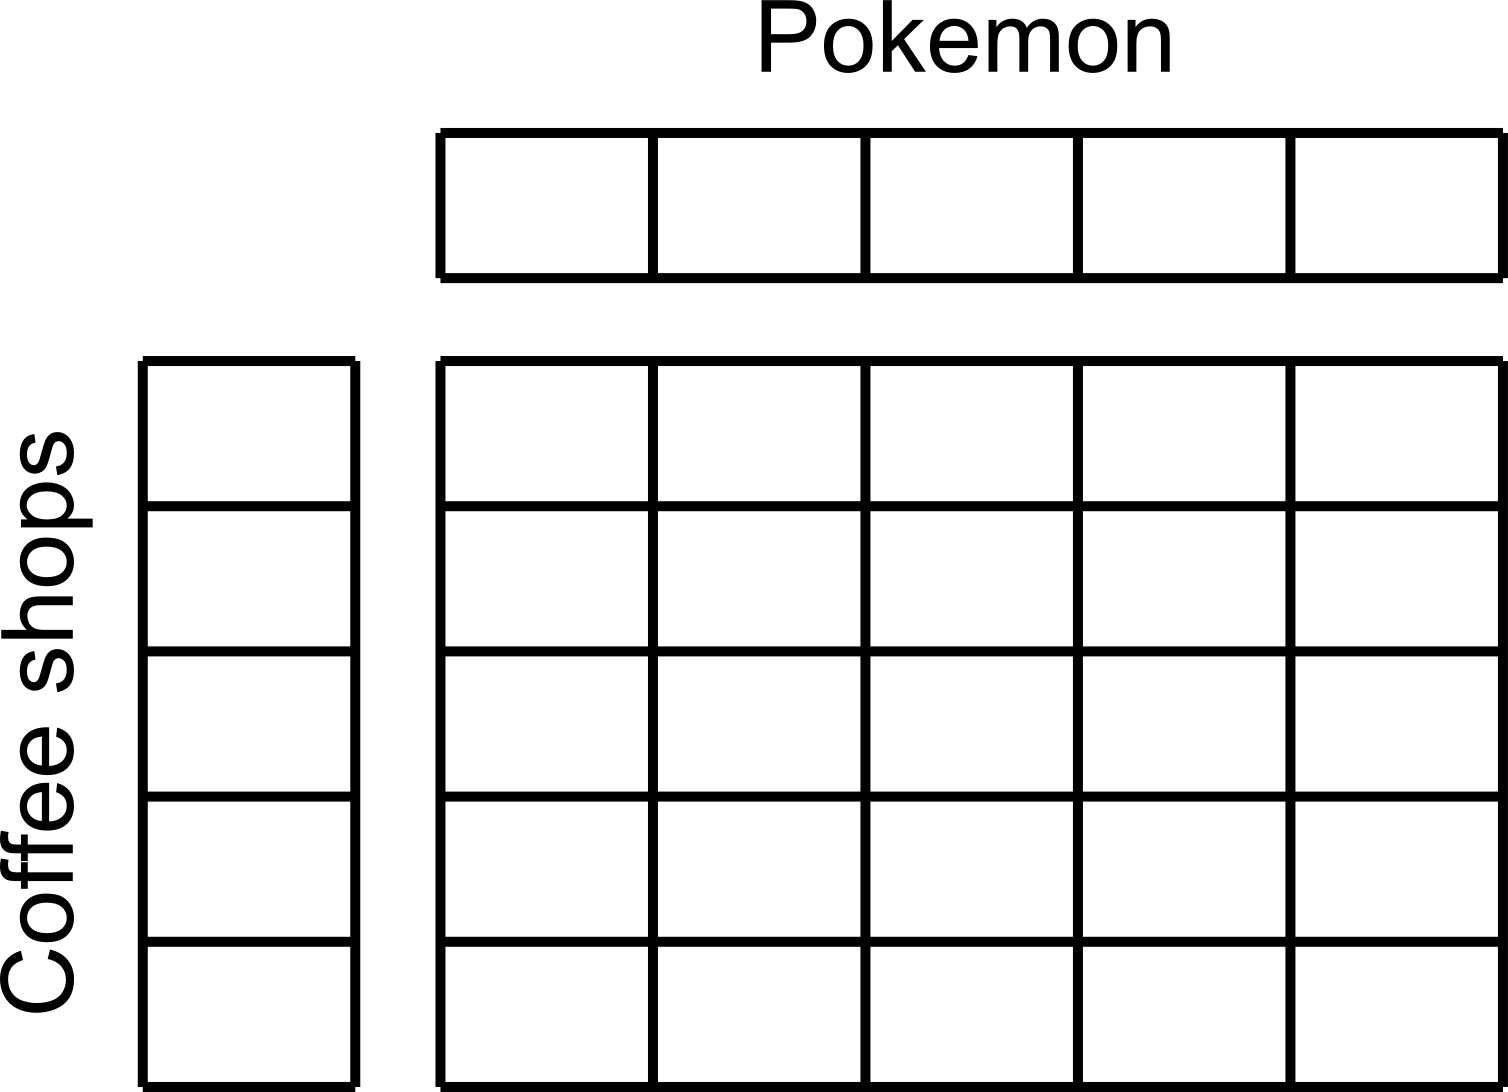

In [2]:
Image(filename= 'Distance grid.png', width=600) 

$Time\ complexity = P_{pokemon} * C_{coffee shops} \approx O(n^2)$

## KDTrees are much faster

$Time\ complexity = P_{pokemon} * log(C_{coffee shops}) \approx O(n\ log(n))$

## KDTrees are just multidimensional Binary Search Trees
For geographic information, this means the binary search tree alternates latitude (North / South) and longitude (East / West).

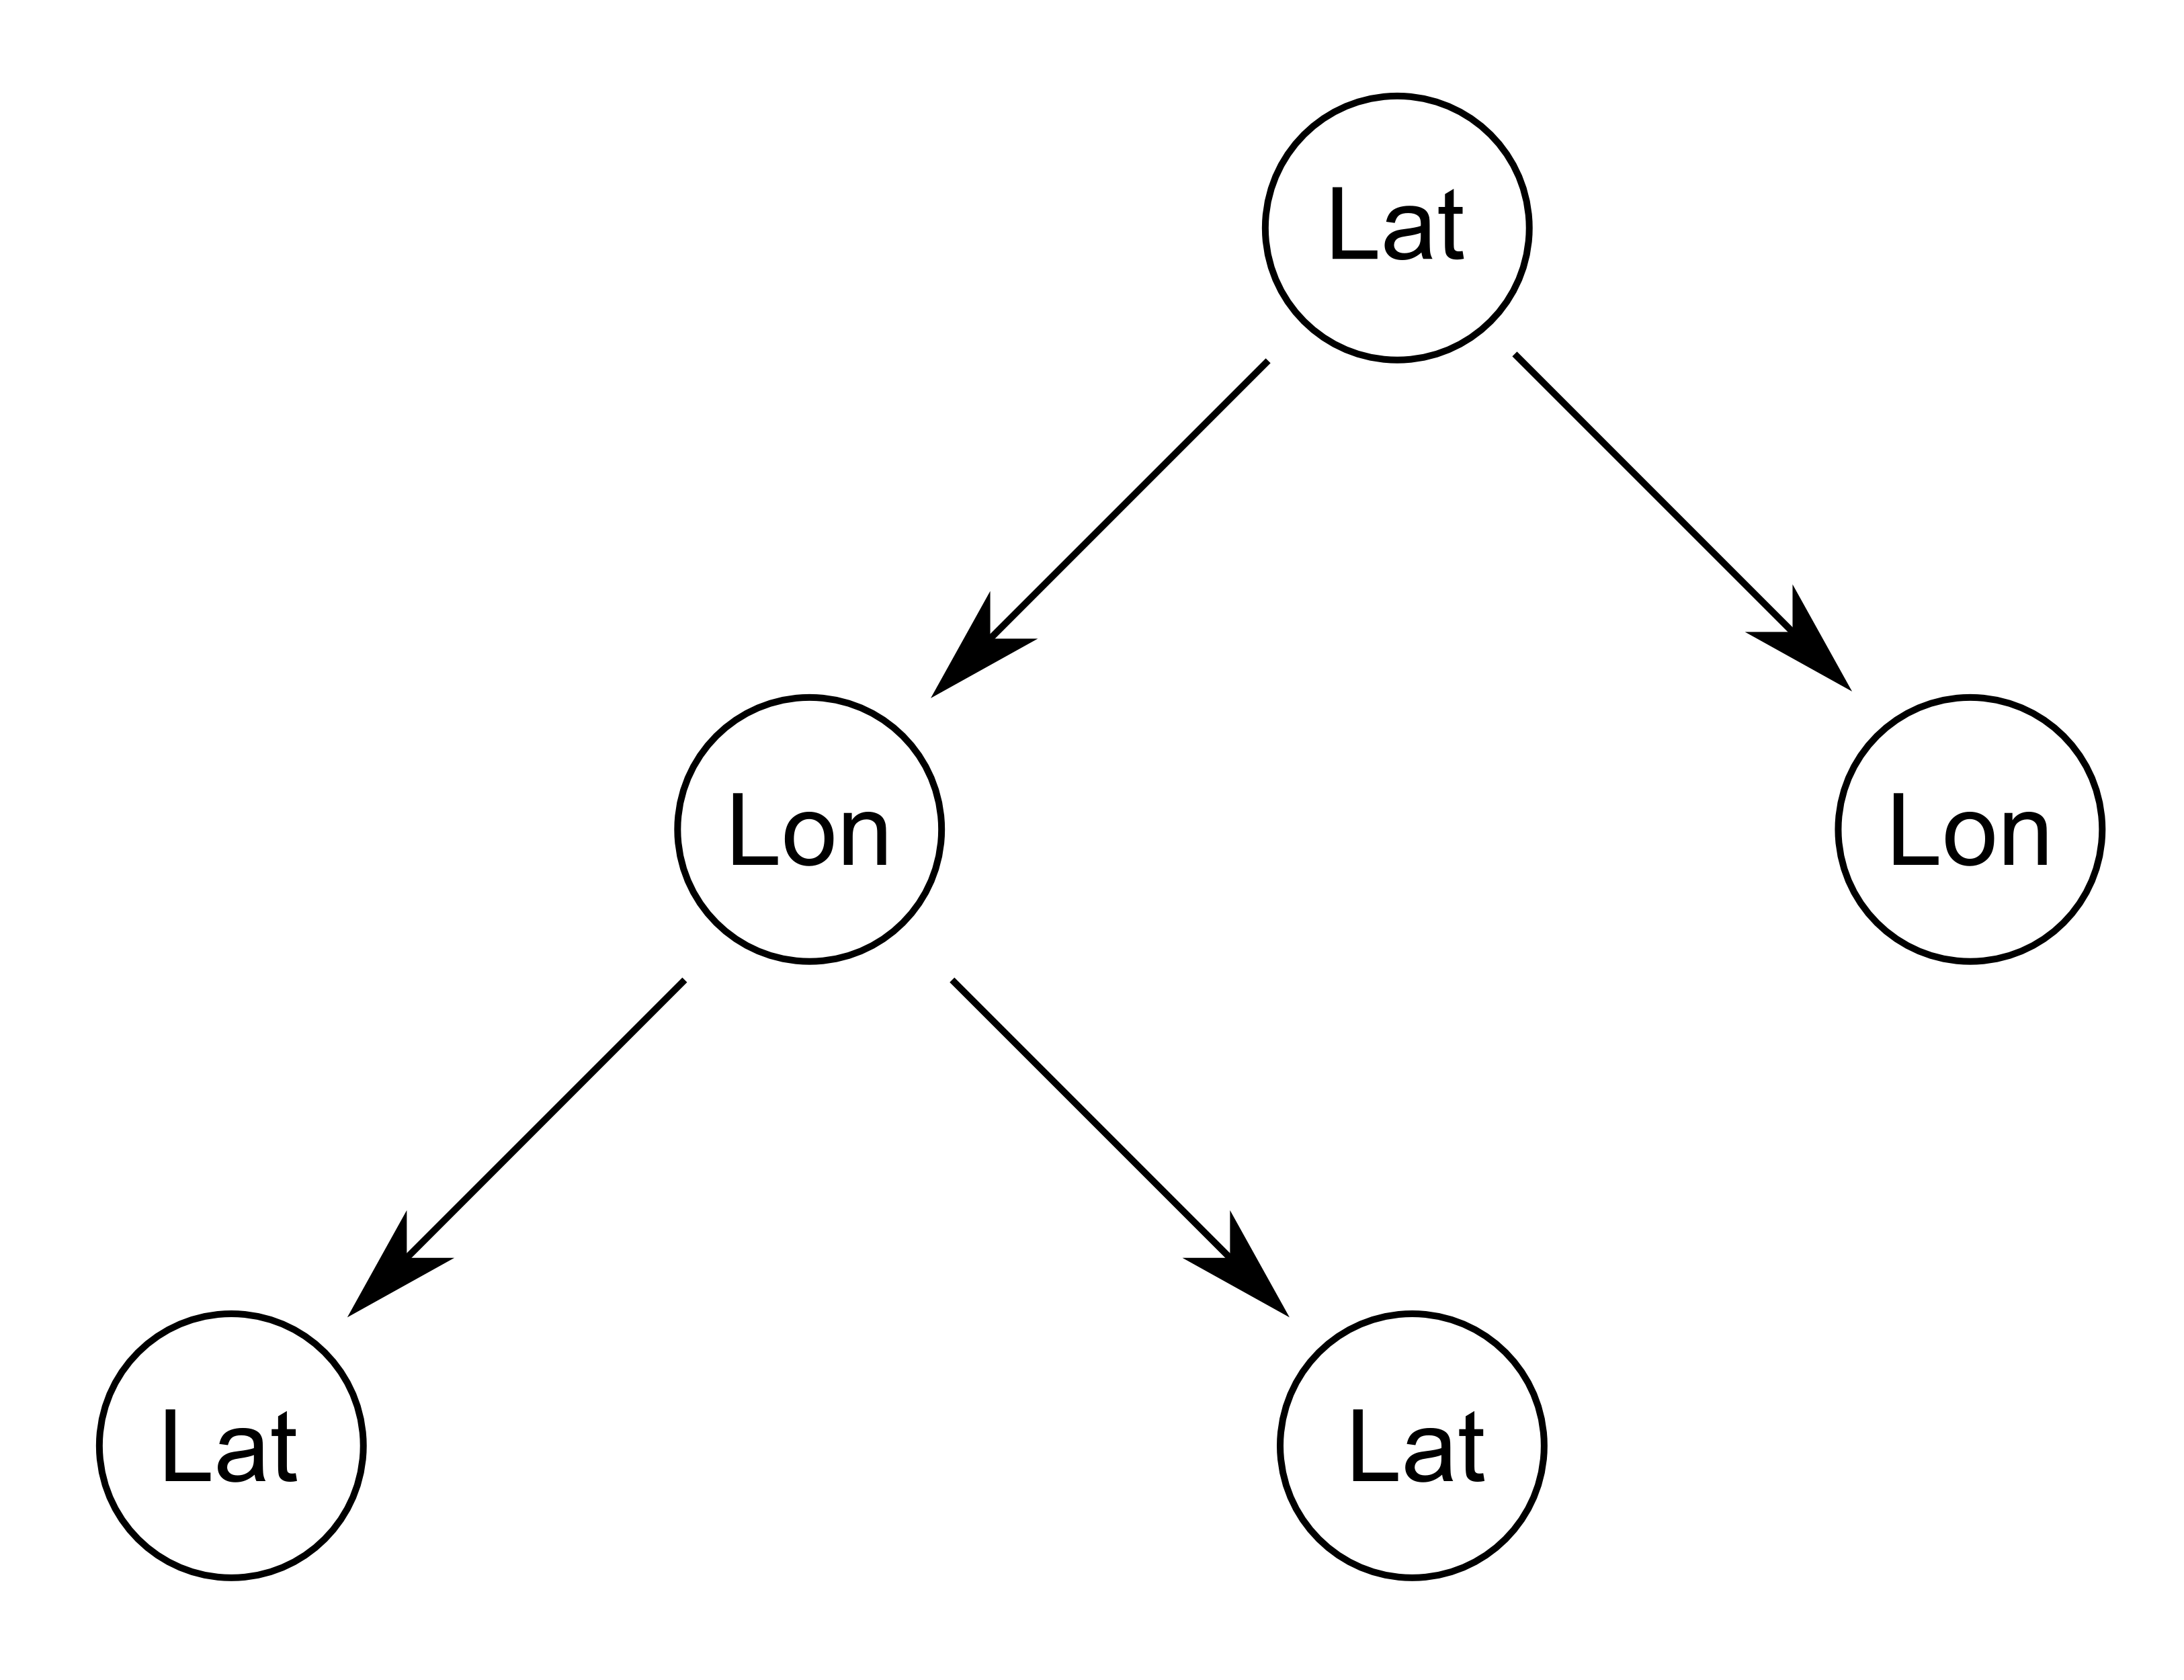

In [3]:
Image(filename= 'Full Tree.png', width=600) 

# Example of how a KDTree would find the closest coffee shop to a Pokemon

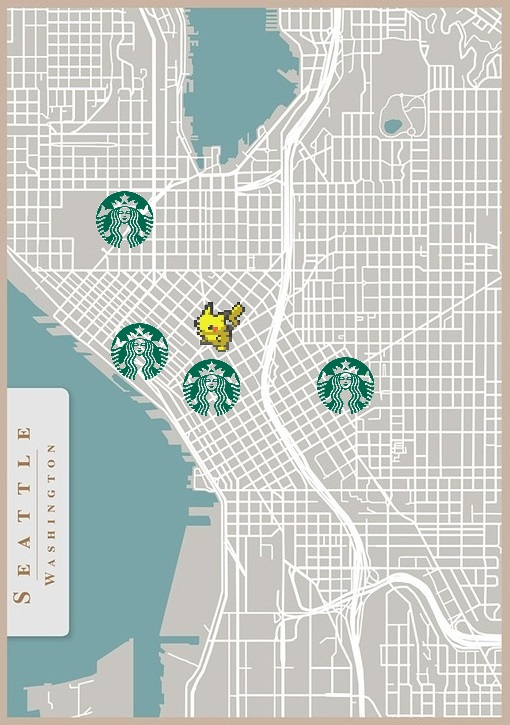

In [8]:
# map taken from delovelyArts on Etsy
Image(filename= 'Seattle.jpg', width=600) 

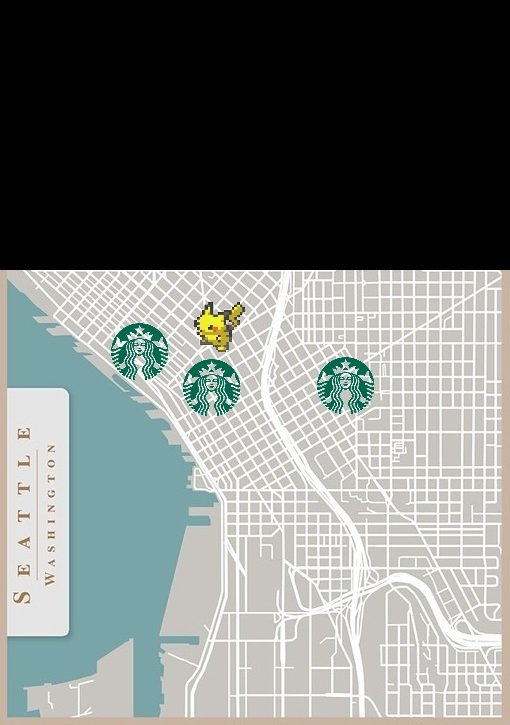

In [9]:
Image(filename= 'Seattle-2.jpg', width=600) 

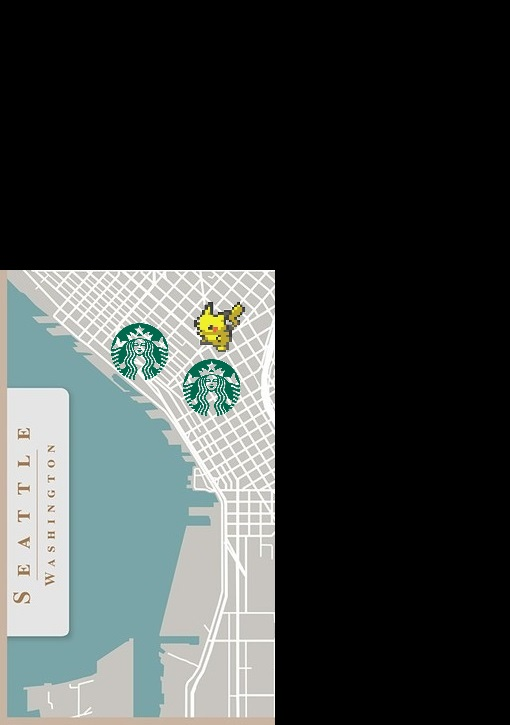

In [10]:
Image(filename= 'Seattle-3.jpg', width=600) 

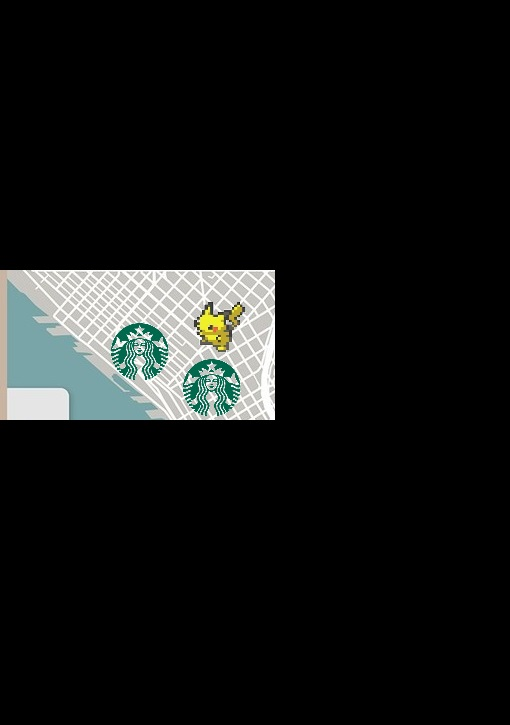

In [11]:
Image(filename= 'Seattle-4.jpg', width=600) 

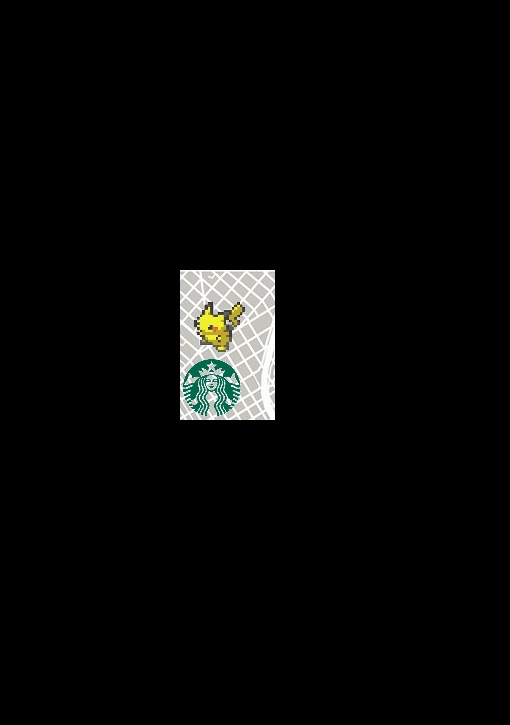

In [13]:
Image(filename= 'Seattle-5.jpg', width=600) 

# Practical example: finding the coffee shop in Hong Kong with the most Pokemon nearby

## Why Hong Kong?

Niantic (Nintendo) doesn't make is easy to scrape Pokemon data.

Nintendo is constantly changing the encryption and API calls, as well as shutting down bot accounts. I tried downloading the data using hacked APIs, but could never get it to work.

### Downloaded location data from http://pokemon.appx.hk

Manually scraped location data from .xhr files, and pasted into JSONs.

## What does the Pokemon data look like?

In [2]:
hk_poke_df = pd.read_csv('hk_pokemon.csv', names=['lat', 'lon', 'ts', 'type'])

In [ ]:
def load_poke_json( pokefile):
    return pd.read_json( pokefile ).rename(columns={'a':'lat', 'i':'type', 't':'ts', 'o':'lon'})
hk_poke_json = glob.glob('data/hk-*.json')
hk_poke_df = pd.concat( [load_poke_json(x) for x in  hk_poke_json ] )

In [3]:
# hk_poke_df is a pandas dataframe
hk_poke_df[['lat', 'lon', 'type']].head()

,lat,lon,type
0,22.208449,114.031100,8
1,22.223130,114.120200,56
2,22.248989,113.944586,74
3,22.254273,113.863911,35
4,22.444772,114.050984,84


In [96]:
hk_poke_df['lat'].count()

18732

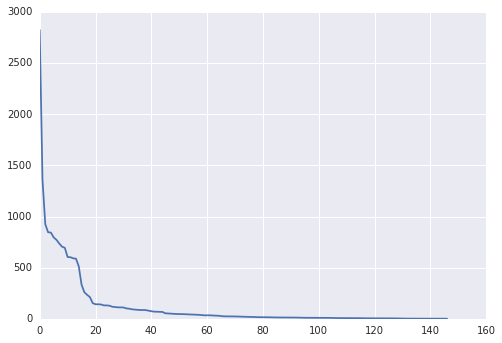

In [93]:
import seaborn as sns
plt.plot(hk_poke_df.type.value_counts().values );

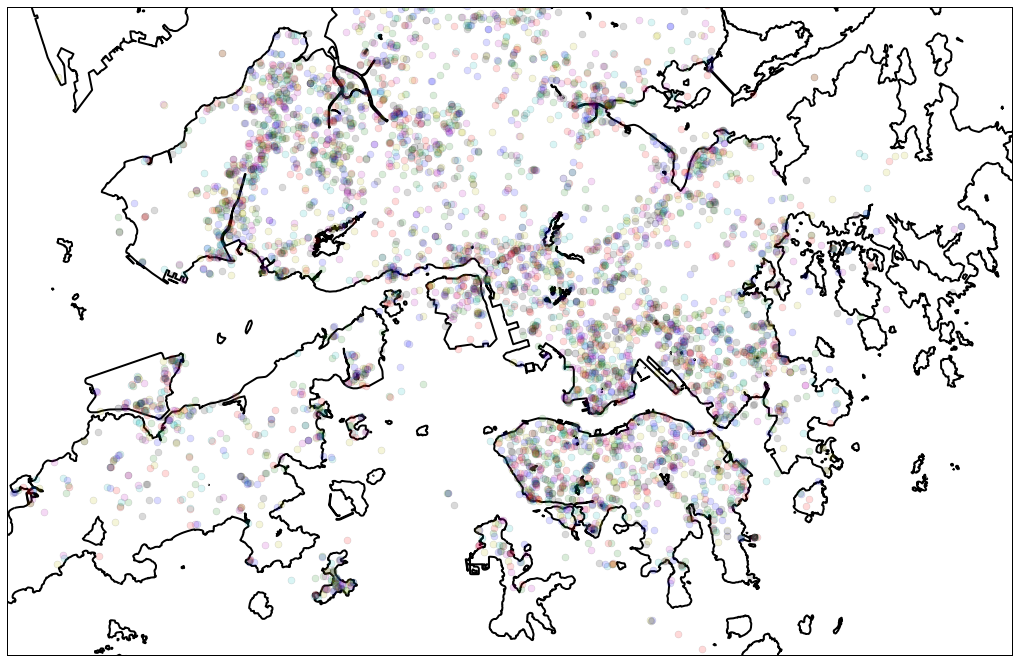

In [68]:
from mpl_toolkits.basemap import Basemap
lw = 2

fig, ax = plt.subplots(1,figsize = (18,12))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.17,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong', linewidth=2)
map.readshapefile('shapefiles/hong_kong_coastline', 'coast', linewidth=2)
for index, pokemon in hk_poke_df.head(5000).iterrows():
    map.plot(pokemon['lon'],pokemon['lat'] , latlon=True, marker = 'o', markersize = 7, alpha = 0.15)
plt.show()

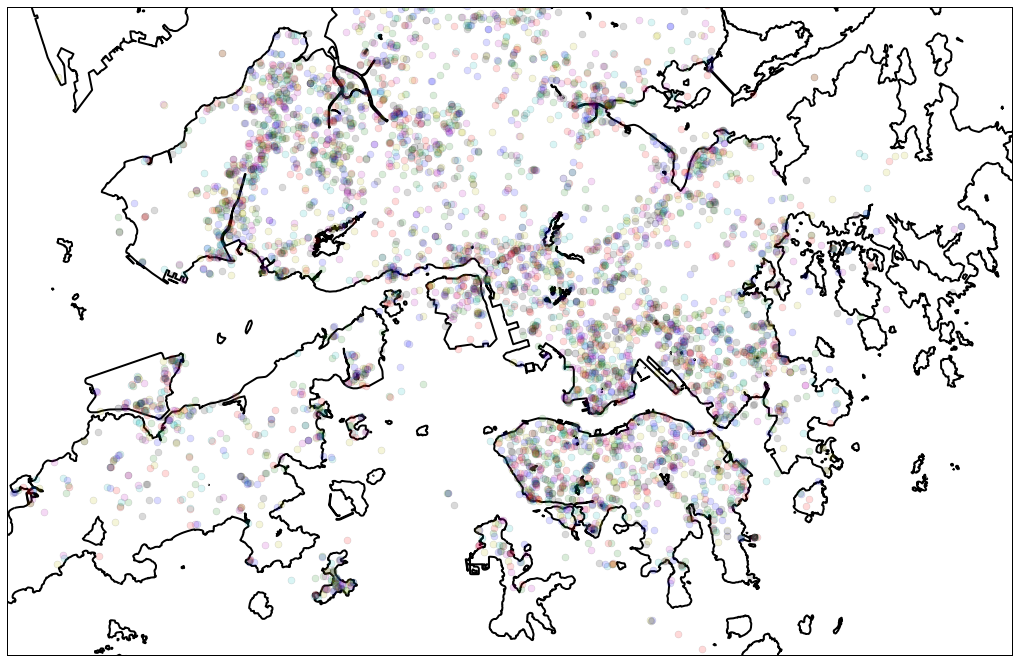

In [68]:
from mpl_toolkits.basemap import Basemap
# (basemap stuff)
plt.show()

# Downloaded coffee shop locations from Foursquare
Searched for coffe shops using a grid of latitude / longitude coordinates

In [3]:
hk_coffee_df = pd.io.json.json_normalize( json.loads(open('hk_coffee.json').read() ) )[['location.lat', 'location.lng', 'name']]
hk_coffee_df.head(3)

,location.lat,location.lng,name
0,22.308377,113.918438,Starbucks
1,22.311764,113.917056,Pacific Coffee
2,22.227676,113.932410,Baby's Coffee Store


In [11]:
hk_coffee_df.name.count()

586

### How many Starbucks are there?

In [18]:
hk_coffee_df.name.str.startswith('Starbucks').sum()

150

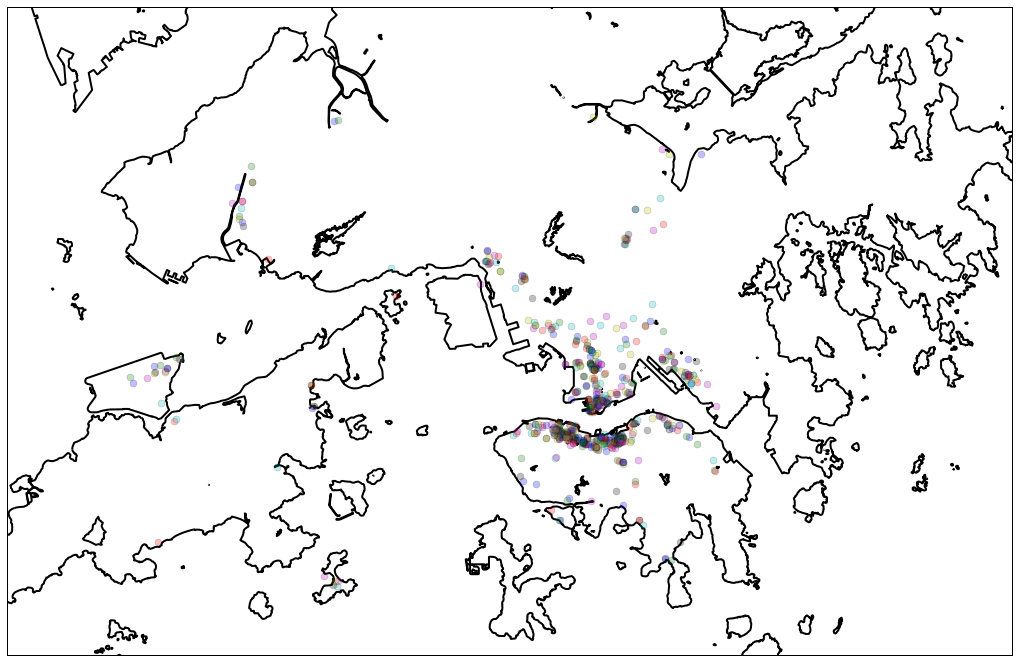

In [71]:
fig, ax = plt.subplots(1,figsize = (18,12))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.17,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong', linewidth =lw)
map.readshapefile('shapefiles/hong_kong_coastline', 'coast', linewidth =lw)
for index, coffee_shop in hk_coffee_df.iterrows():
    map.plot(coffee_shop['location.lng'],coffee_shop['location.lat'],
             latlon=True, marker = 'o', markersize = 7, alpha = 0.25)
plt.show()

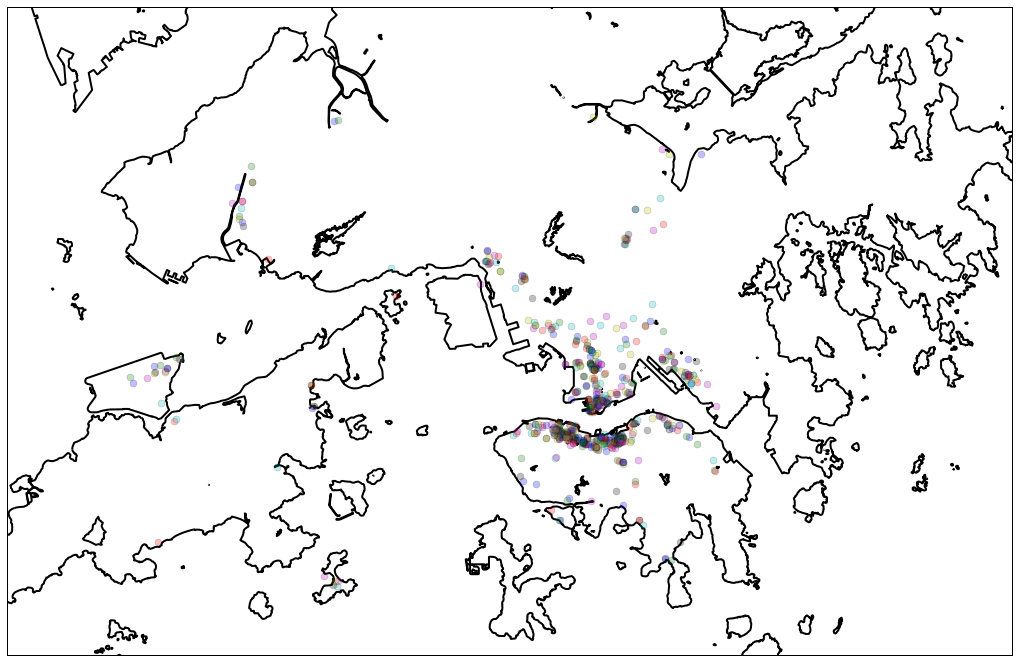

In [71]:
fig, ax = plt.subplots(1,figsize = (18,12))
#(basemap stuff)
plt.show()

# Let's calculate some distances!
First, let's try the brute force algorithm

In [13]:
from sklearn.metrics.pairwise import euclidean_distances

In [14]:
%%timeit
distances = euclidean_distances(hk_coffee_df[['location.lat', 'location.lng']],
                                hk_poke_df[['lat', 'lon']])

1 loop, best of 3: 173 ms per loop


In [32]:
hk_coffee_df['brute_pokemon'] = [np.sum(x < 0.0005) for x in distances]
hk_coffee_df.query('brute_pokemon > 5')

,location.lat,location.lng,name,brute_pokemon
40,22.207968,114.029331,Coffee Seeds 阿翁,6
64,22.270550,114.130811,Pacific Coffee (太平洋咖啡),6
333,22.318484,114.174676,Starbucks,7


# Let's see how fast KDTrees are

In [4]:
from scipy.spatial import cKDTree

%time coffee_kdtree = cKDTree( hk_coffee_df[['location.lat', 'location.lng']] )

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.24 ms


In [5]:
%%timeit -n1 -r1
radius = 0.0005 # the pokemon should be within ~50 meters of a coffee shop

kdtree_counts = coffee_kdtree.query( hk_poke_df[['lat', 'lon']],
                                    
                                    k=10, # return a maximum of 10  shops
                                    
                                    distance_upper_bound=radius )

1 loop, best of 1: 12.8 ms per loop


In [37]:
radius = 0.0005
kdtree_counts = coffee_kdtree.query( hk_poke_df[['lat', 'lon']],
                                    k=10, # return a maximum of 10  shops
                                    distance_upper_bound=radius )

In [41]:
hk_coffee_df['kdtree_pokemon'] = pd.Series( kdtree_counts[1].ravel() ).value_counts()
hk_coffee_df = hk_coffee_df.fillna(0)
hk_coffee_df.query('kdtree_pokemon > 5')

,location.lat,location.lng,name,brute_pokemon,kdtree_pokemon
40,22.207968,114.029331,Coffee Seeds 阿翁,6,6.0
64,22.270550,114.130811,Pacific Coffee (太平洋咖啡),6,6.0
333,22.318484,114.174676,Starbucks,7,7.0


# Where is the best coffee shop?

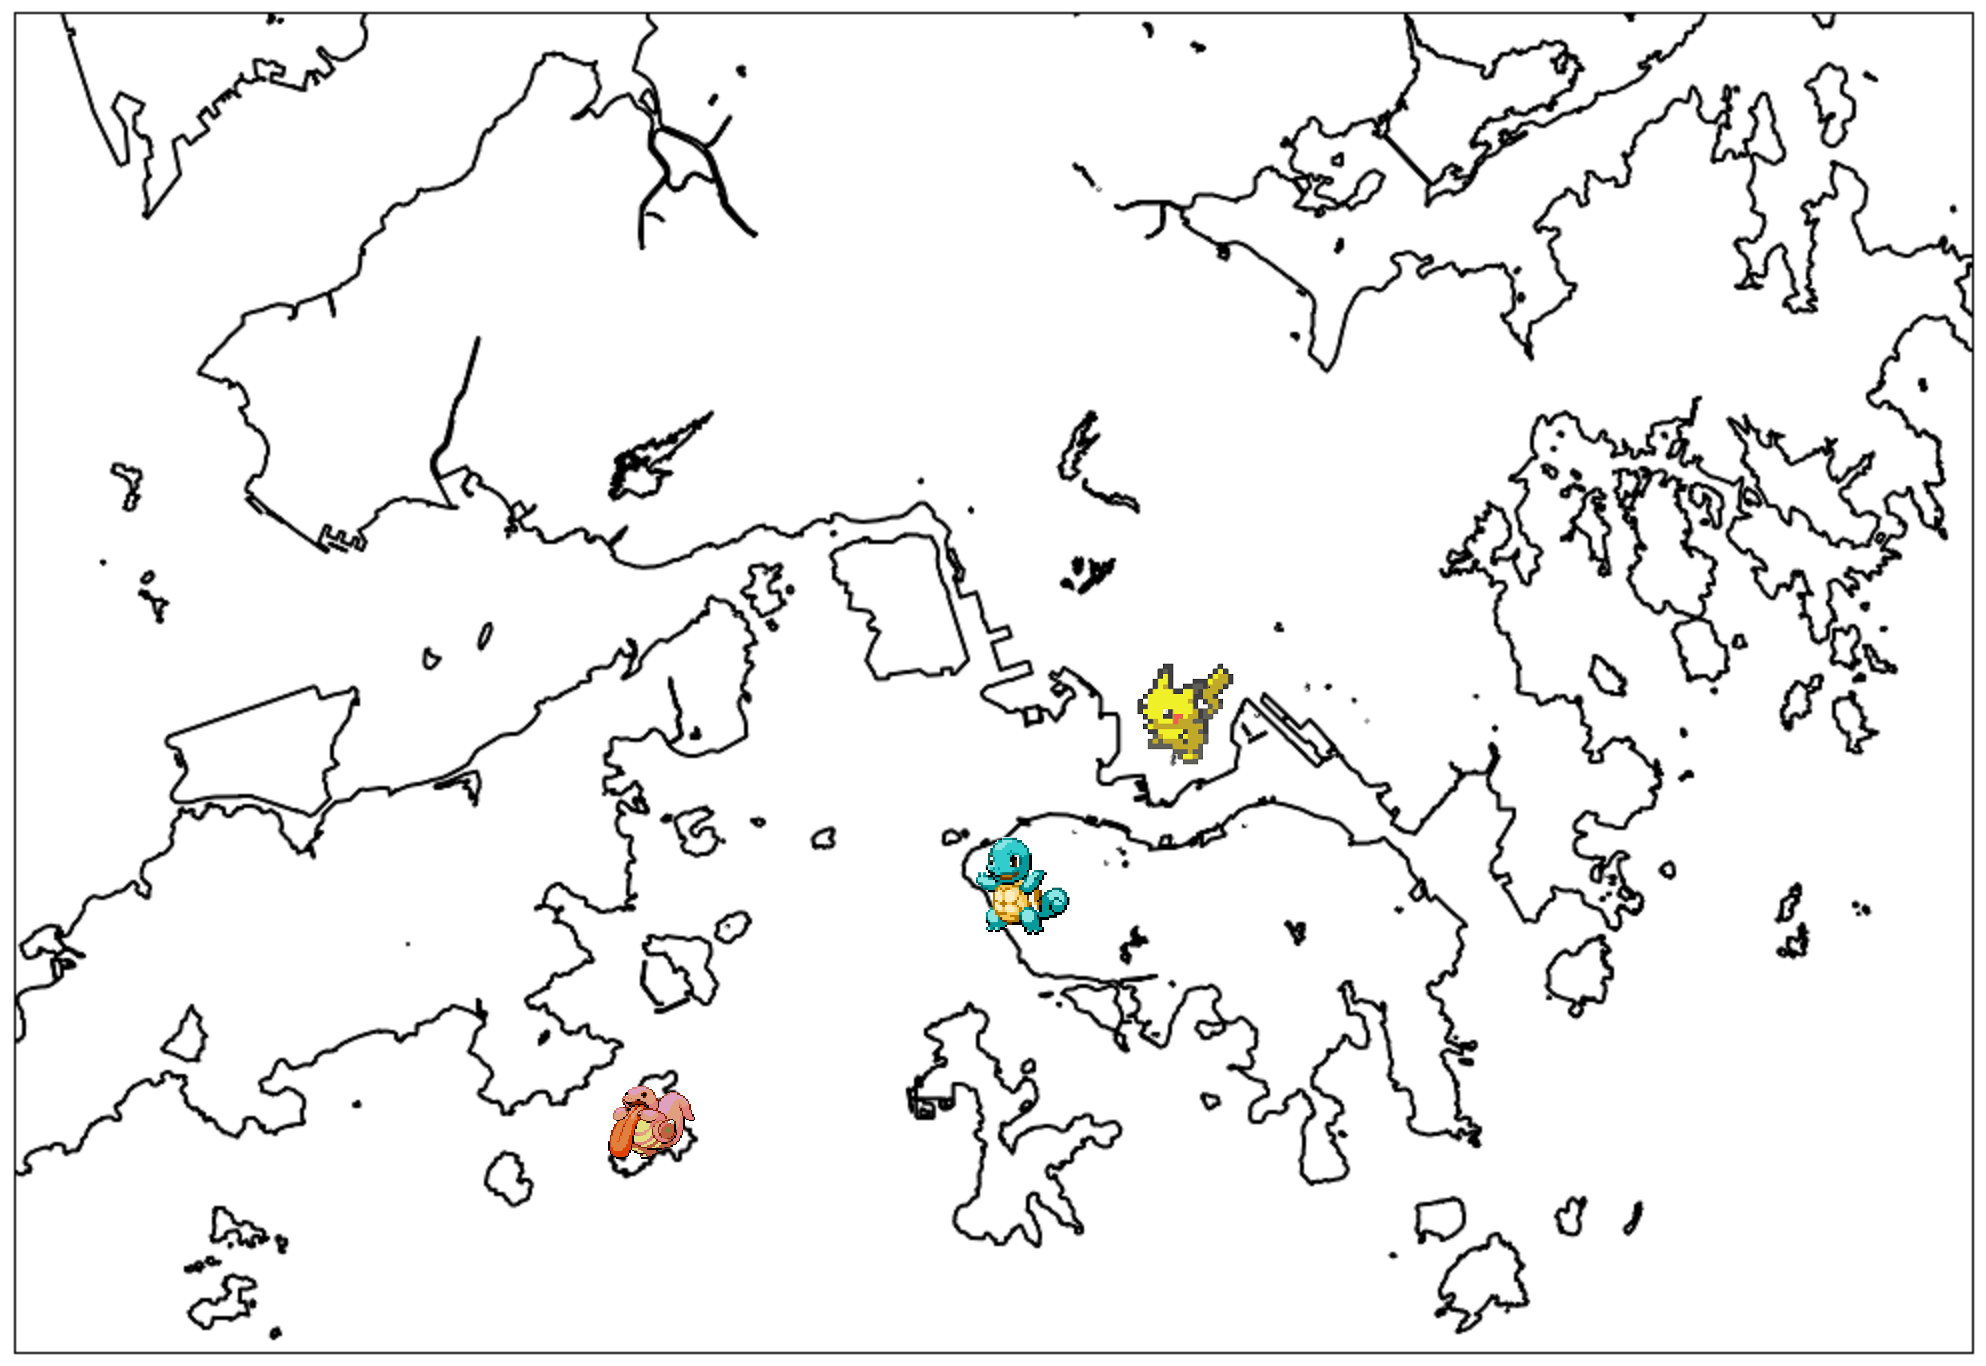

In [74]:
Image(filename= 'graphics/final map.png', width=1200) 

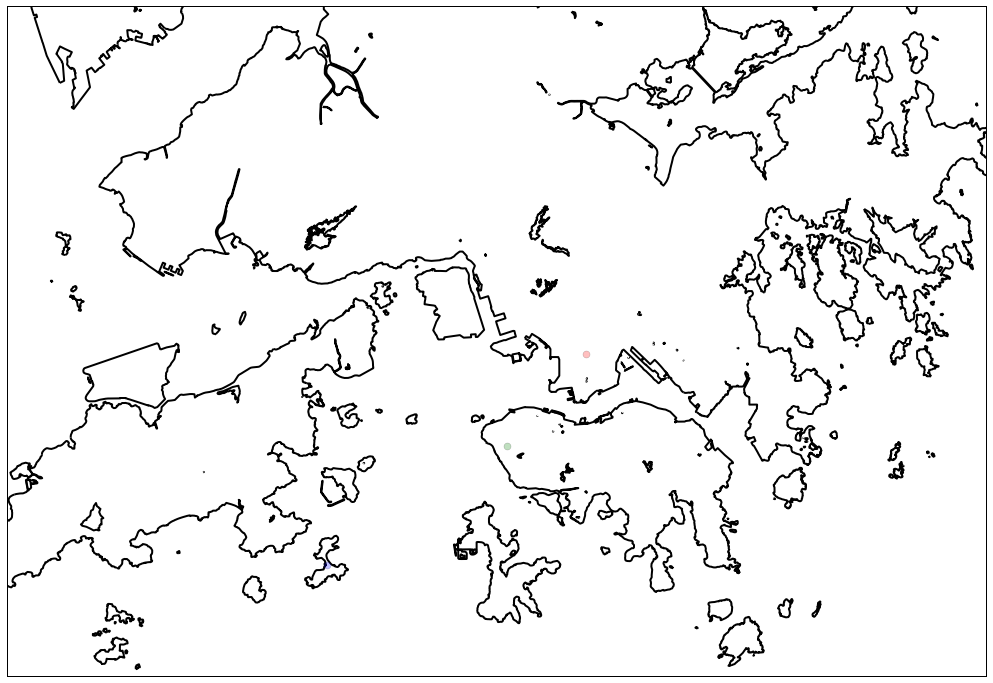

In [72]:
import matplotlib.image as image
fig, ax = plt.subplots(1,figsize = (18,12))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.15,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong', linewidth =lw )
map.readshapefile('shapefiles/hong_kong_coastline', 'coast', linewidth =lw)
for index, coffee_shop in hk_coffee_df.query('kdtree_pokemon > 5').iterrows():
    map.plot(coffee_shop['location.lng'],coffee_shop['location.lat'],
             latlon=True, marker = 'o', markersize = 7, alpha = 0.25)
plt.show()

# Part II: Spark
Spark is a big data framework

* Not a programming language

* APIs for Java, Scala, python, and R

Written in Scala.

Keeps everything in memory

For ~$2 / hour you can get 80 CPUs, and 320GB of computers

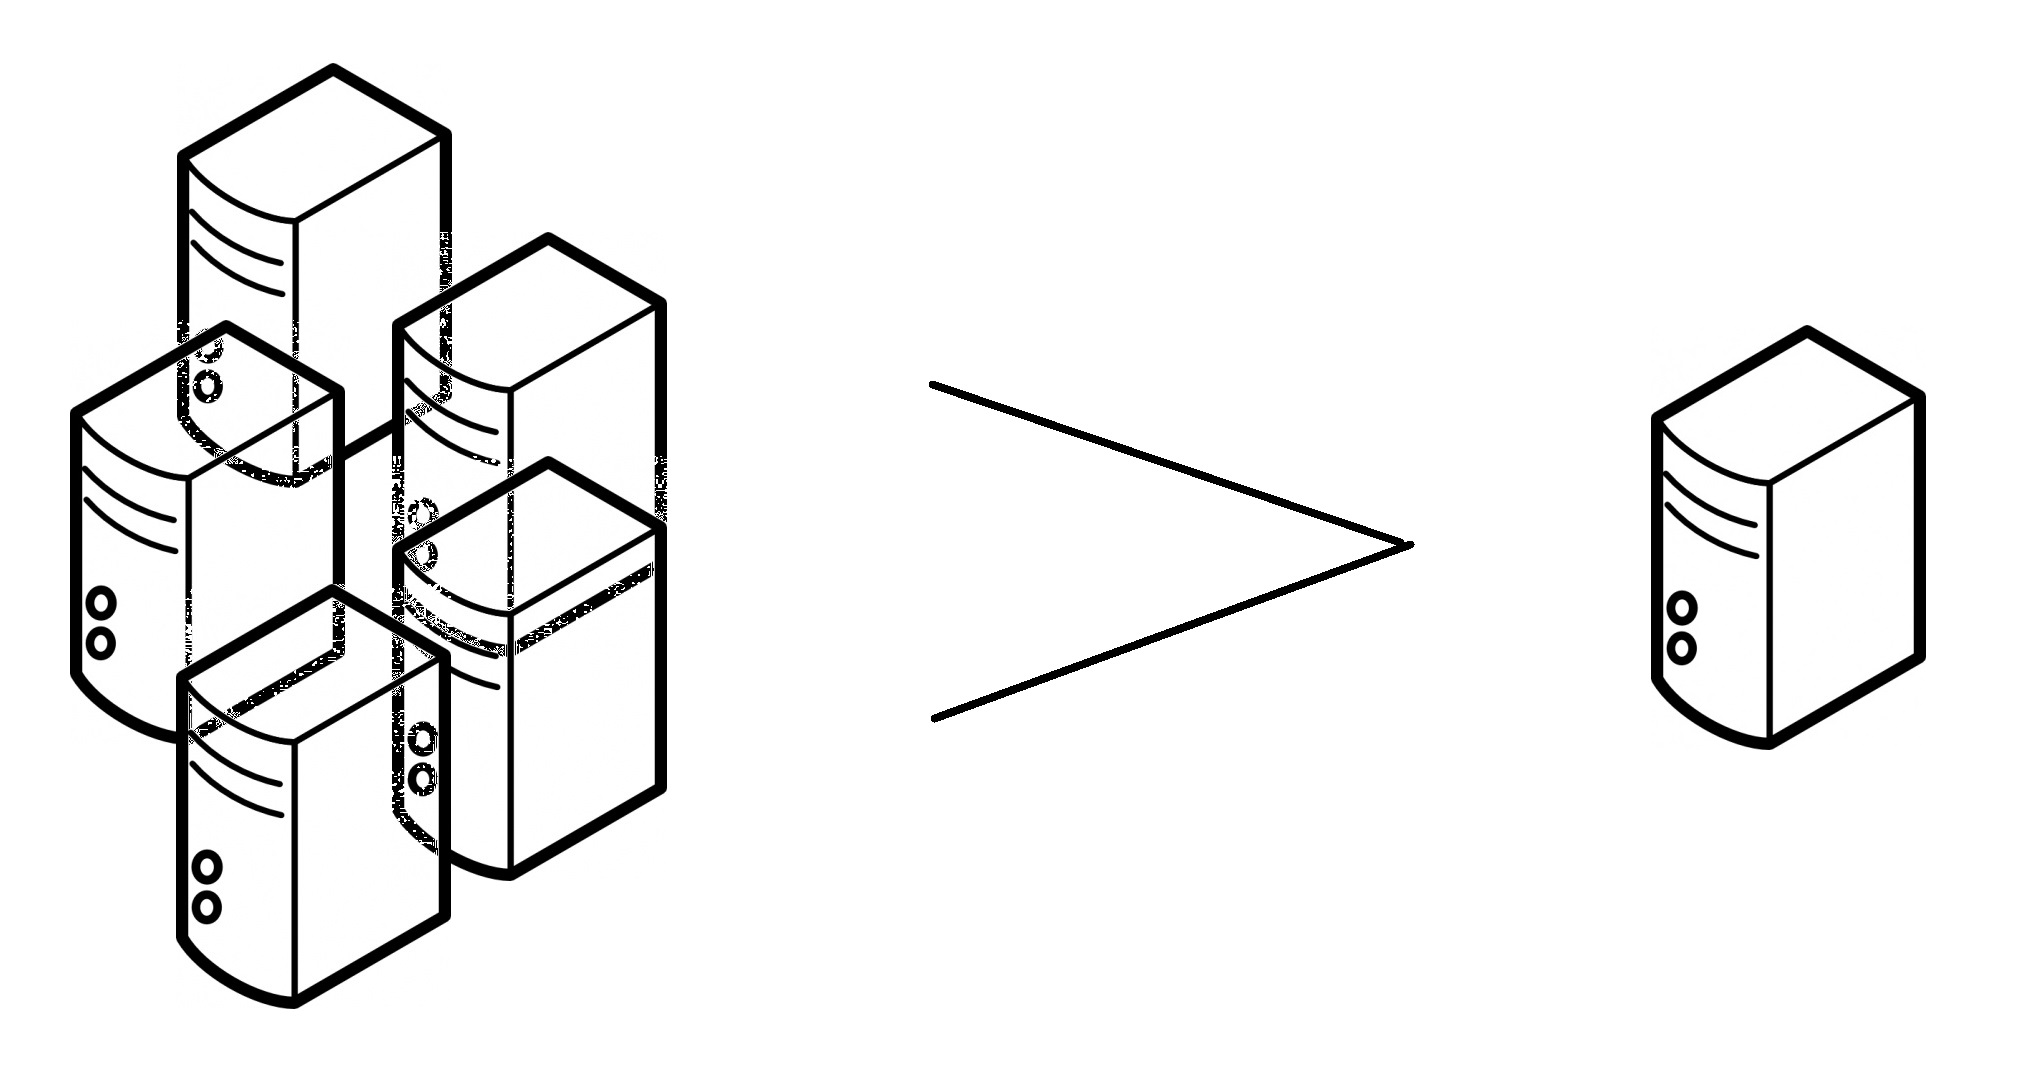

In [26]:
Image('graphics/many computers.jpg', width=600)

## Importing data is really easy

In [5]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
coffee_tree_broadcast = sc.broadcast( coffee_kdtree )
mid_poke_df = pd.concat([hk_poke_df[['lat', 'lon', 'ts', 'type']]]*100)
# Creating Spark dataframes from pandas dataframes is super easy

In [6]:
poke_spark_df = spark.createDataFrame( mid_poke_df)

### Spark is great at SQL like queries

In [17]:
(poke_spark_df.groupby('type')
              .count()
#              .orderBy('count', ascending=False)
              .show(5) )

+----+-----+
|type|count|
+----+-----+
|  61|11200|
|  63|70500|
|  27|84600|
| 125| 9000|
|  18|11100|
+----+-----+
only showing top 5 rows



## Querying millions of datapoints
Let's try making a larger dataset

In [14]:
big_poke_df = pd.concat([hk_poke_df[['lat', 'lon', 'ts', 'type']]]*5000)
big_poke_df['lat'] += np.random.rand( big_poke_df.shape[0]) / 100 - 0.005
big_poke_df['lon'] += np.random.rand( big_poke_df.shape[0]) / 100 - 0.005
big_poke_df.shape

(93660000, 4)

### How long does this query take on one computer?

In [8]:
%%timeit -n1 -r1
radius = 0.0005 # the pokemon should be within ~50 meters of a coffee shop

kdtree_counts = coffee_kdtree.query( big_poke_df[['lat', 'lon']],
                                    
                                    k=10, # return a maximum of 10  shops
                                    
                                    distance_upper_bound=radius )

1 loop, best of 1: 55.6 s per loop


## Querying KDTrees in Spark
Use `union` to make a large Spark dataframe

In [9]:
big_spark_df = poke_spark_df

for i in range(6): # this will actually be 2^6, or 64x
    big_spark_df = big_spark_df.union(big_spark_df)

big_spark_df.count()

119884800

In [7]:
big_spark_df = spark.read.csv('s3://sewichi-test/patterson/temp/pokemon/spark_df/', schema = poke_spark_df.schema).persist( StorageLevel.MEMORY_ONLY)

In [8]:
big_spark_df.count()

119884800

Then we need to add some jitter to the latitude and longitudes

In [ ]:
big_spark_df = (big_spark_df.withColumn('lat', F.col('lat') + F.rand() / 100 - 0.005)
                            .withColumn('lon', F.col('lon') + F.rand() / 100 - 0.005) )

## Setting up the query
Takes two steps:
Write a query function

In [11]:
def query_kdtree( lat, lon, cur_tree, radius = 0.0005):

    query_results = cur_tree.value.query( [lat, lon],
                                          k = 10,
                                          distance_upper_bound=radius)
    
    # this is adapter code for Spark
    return [int(row[1]) for row in zip(*query_results) if row[0] < radius]

### Write a query wrapper

In [12]:
from functools import partial
coffee_udf = F.udf( partial( query_kdtree,
                             cur_tree = coffee_tree_broadcast),
                    T.ArrayType( T.IntegerType() ) )

### Actually run the query.

In [13]:
%%timeit -n1 -r1
nearby_df = (big_spark_df.withColumn('nearby_shops', coffee_udf('lat', 'lon'))
nearby_df.count()

1 loop, best of 1: 13min 56s per loop


## That was really slow!

In [ ]:
query_results = cur_tree.value.query( [lat, lon], # <- single coordinate
                                      k = 10,
                                      distance_upper_bound=radius)

## Can we speed things up?

In [9]:
def query_kdtree_mappartitions(iterator):
    radius = 0.0005
    
    lat_lons = [(x.asDict()['lat'], x.asDict()['lon']) for x in iterator]
    
    kdtree_counts = coffee_tree_broadcast.value.query( lat_lons, # <-- list of coordinates
                                                       10,
                                                       radius)
    
    # more Spark adaptor code
    return Row( kdtree_counts[1].ravel().tolist() )

In [10]:
%%timeit -n1 -r1
nearby_rdd = big_spark_df.rdd.mapPartitions( query_kdtree_mappartitions )
nearby_rdd.count()

1 loop, best of 1: 3min 20s per loop


## Spark is useful for datasets that don't fit in memory

## KDTrees are an easy, fast way to calculate nearest neighbors

## Go to Coffee Seeds to catch some Pokemon!

## Use Spark for billions of data points

* But not for millions

# Go catch some Pokemon!
https://github.com/map222/trailofpapers/tree/master/pokemon

@trailofpapers

www.trailofpapers.net

### Further notes on complexity
$Build\ complexity = O(n\ log(n) )$

$Search\ complexity = O( log(n) )$


With this data we can answer some simple questions. For example, how many pokemon had a coffee shop nearby?

In [14]:
nearby_df.select('lat', 'lon', 'ts', 'type').distinct().count()

285

Or we can ask how many shops had at least one Pokemon nearby.

In [15]:
(nearby_df.select('shop_index').distinct().count() )

240